# CV Model

In [19]:
# Import required libraries
import tensorflow as tf
import os
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample



pd.set_option('display.max_rows', 500)

In [20]:
# Define globals
data_directory = './/data'  #dataset path
fs = 5  # Sampling frequency for piano rolls
labeled_midi_data = {}

def load_midi_data_and_labels(directory):
    skipped_files = []    # Keep track of skipped files due to errors
    data = []
    composers = []
    num_composer_map = {}
    # Function to recursively iterate files in a directory
    def iterate_dir(dir_path, label, composer):        
        # Check direct .mid files in current directory
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isfile(item_path) and item_path.endswith('.mid'):
                try:
                    # Load the MIDI file
                    midi_data = pretty_midi.PrettyMIDI(item_path)
                    data.append(midi_data)
                    composers.append(label)
                    if label not in labeled_midi_data:
                        labeled_midi_data[label] = []
                    labeled_midi_data[label].append(midi_data)

                except Exception as e:  # Catch any exception that might be raised
                    print(f"Skipping file {item_path} due to an error: {e}")
                    skipped_files.append(item_path)
            elif os.path.isdir(item_path):
                iterate_dir(item_path, label, composer)
        print(f"Number of files skipped due to error: {len(skipped_files)}")
        return

    # Process each composer's directory in the root directory
    for label, composer in enumerate(sorted(os.listdir(directory))):
        composer_path = os.path.join(directory, composer)
        if os.path.isdir(composer_path):
            num_composer_map[label] = composer
            iterate_dir(composer_path, label, composer)

    return np.array(data), np.array(composers), num_composer_map

_, _, num_composer_map = load_midi_data_and_labels(data_directory)

Number of files skipped due to error: 0
Skipping file .//data\Beethoven\Anhang 14-3.mid due to an error: Could not decode key with 3 flats and mode 255
Number of files skipped due to error: 1
Number of files skipped due to error: 1


c:\Users\kflin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of files skipped due to error: 1


In [21]:
print(labeled_midi_data)

{0: [<pretty_midi.pretty_midi.PrettyMIDI object at 0x000002485210E8D0>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024921A172D0>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024846B50150>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024925C38110>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x00000248470FC090>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024844868150>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x000002484413C090>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024846F74290>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x000002484694C090>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024921A83390>], 1: [<pretty_midi.pretty_midi.PrettyMIDI object at 0x00000248468B0210>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024845578CD0>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000024845578C50>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x00000248442CF1D0>, <pretty_midi.pretty_midi.PrettyMIDI object at 0x0000

In [22]:
# SongData object. Contains the composer name, the composer id, the midi data, the piano roll, and the windows of the piano roll
class Song:
    def __init__(self, composer, composer_id, midi_data):
        self.composer = composer
        self.composer_id = composer_id
        self.midi_data = midi_data
        self.piano_roll = self.create_piano_roll()
        self.windows = self.create_windows()
        self.windows_with_augmentation = self.create_windows_with_augmentation()

    def create_piano_roll(self):
        piano_roll = self.midi_data.get_piano_roll(fs=fs)
        return piano_roll

    def augment_data(self):
        augmented_piano_rolls = []
        # Shift the piano roll up and down
        for i in range(-5,5):
            augmented_piano_rolls.append(np.roll(self.piano_roll, i, axis=0))

        # Add noise to the piano roll
        augmented_piano_rolls.append(self.piano_roll + np.random.normal(0, 0.1, self.piano_roll.shape))

        return augmented_piano_rolls

    def create_windows(self, window_size=128, stride=128):
        piano_roll_tensor = tf.convert_to_tensor(self.piano_roll)
        width = piano_roll_tensor.shape[1]
        starts = tf.range(0, width - window_size, stride)
        windows = tf.stack([piano_roll_tensor[:, start:start + window_size] for start in starts], axis=0)
        return windows
    
    def create_windows_with_augmentation(self, window_size=128, stride=128):
        augmented_piano_rolls = self.augment_data()
        windows = []
        for piano_roll in augmented_piano_rolls:
            piano_roll_tensor = tf.convert_to_tensor(piano_roll)
            width = piano_roll_tensor.shape[1]
            starts = tf.range(0, width - window_size, stride)
            windows.extend([piano_roll_tensor[:, start:start + window_size] for start in starts])
        return windows
    
    def print_piano_roll(self):
        plt.figure(figsize=(12, 6))
        plt.imshow(self.piano_roll, origin='lower', aspect='auto', cmap='gray')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pitch')
        plt.title('Piano Roll Representation of MIDI File')
        plt.show()

    def print_info(self):
        print(f"Composer: {self.composer}")
        print(f"Composer ID: {self.composer_id}")
        print(f"Number of windows: {len(self.windows)}")
        print(f"Window shape: {self.windows[0].shape}")

In [23]:
songs = []
for composer_id, composer in labeled_midi_data.items():
    for midi_data in composer:
        song = Song(num_composer_map[composer_id], composer_id, midi_data)
        songs.append(song)
        #song.print_info()

print(len(songs))

40


In [24]:
# train test split

train_songs = {}
test_songs = {}

for song in songs:
    if song.composer_id not in test_songs:
        test_songs[song.composer_id] = []
    if len(test_songs[song.composer_id]) < 2:
        test_songs[song.composer_id].append(song)
    else:
        if song.composer_id not in train_songs:
            train_songs[song.composer_id] = []
        train_songs[song.composer_id].append(song)

train_songs = [song for composer_songs in train_songs.values() for song in composer_songs]
test_songs = [song for composer_songs in test_songs.values() for song in composer_songs]

# print number of training and testing songs for each composer
count_train = {}
count_test = {}
for song in train_songs:
    if song.composer_id not in count_train:
        count_train[song.composer_id] = 0
    count_train[song.composer_id] += 1

for song in test_songs:
    if song.composer_id not in count_test:
        count_test[song.composer_id] = 0
    count_test[song.composer_id] += 1

print(f"Training songs per composer{count_train}")
print(f"Testing songs per composer{count_test}")

# Create a dataset from the training songs
train_windows = []
train_labels = []

for song in train_songs:
    train_windows.extend(song.windows_with_augmentation)
    train_labels.extend([song.composer_id] * len(song.windows_with_augmentation))

train_windows = tf.stack(train_windows)
train_labels = tf.convert_to_tensor(train_labels)

print(f"Training windows shape: {train_windows.shape}")
print(f"Training labels shape: {train_labels.shape}")
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Distinct Training Samples {dict(zip(unique, counts))}")

test_windows = []
test_labels = []

for song in test_songs:
    test_windows.extend(song.windows_with_augmentation)
    test_labels.extend([song.composer_id] * len(song.windows_with_augmentation))

test_windows = tf.stack(test_windows)
test_labels = tf.convert_to_tensor(test_labels)

print(f"Testing windows shape: {test_windows.shape}")
print(f"Testing labels shape: {test_labels.shape}")
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Distinct Training Samples {dict(zip(unique, counts))}")

print(train_labels)

Training songs per composer{0: 8, 1: 7, 2: 8, 3: 9}
Testing songs per composer{0: 2, 1: 2, 2: 2, 3: 2}
Training windows shape: (3784, 128, 128)
Training labels shape: (3784,)
Distinct Training Samples {0: 2189, 1: 396, 2: 528, 3: 671}
Testing windows shape: (1353, 128, 128)
Testing labels shape: (1353,)
Distinct Training Samples {0: 682, 1: 242, 2: 88, 3: 341}
tf.Tensor([0 0 0 ... 3 3 3], shape=(3784,), dtype=int32)


In [25]:
# Convert train_windows and train_labels to numpy arrays
train_windows_np = train_windows.numpy()
train_labels_np = train_labels.numpy()

# SMOTE wants 2D input, need to flatten
n_samples, n_timesteps, n_features = train_windows_np.shape
train_windows_reshaped = train_windows_np.reshape((n_samples, -1))

smote = SMOTE(random_state=42)
train_windows_resampled, train_labels_resampled = smote.fit_resample(train_windows_reshaped, train_labels_np)

# Reshape the resampled windows back to 3D
train_windows_resampled = train_windows_resampled.reshape((-1, n_timesteps, n_features))

# Convert back to tensors
train_windows_balanced = tf.convert_to_tensor(train_windows_resampled)
train_labels_balanced = tf.convert_to_tensor(train_labels_resampled)

print(f"Balanced training windows shape: {train_windows_balanced.shape}")
print(f"Balanced training labels shape: {train_labels_balanced.shape}")
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print(f"Distinct Balanced Training Samples {dict(zip(unique, counts))}")

Balanced training windows shape: (8756, 128, 128)
Balanced training labels shape: (8756,)
Distinct Balanced Training Samples {0: 2189, 1: 2189, 2: 2189, 3: 2189}


In [26]:
# create the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\kflin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# train the model
train_windows = tf.expand_dims(train_windows, axis=-1)
test_windows = tf.expand_dims(test_windows, axis=-1)

#class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels.numpy())
#class_weight_dict = dict(enumerate(class_weights))

model.fit(train_windows, train_labels, epochs=1) # validation_data=(test_windows, test_labels)

119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 208ms/step - accuracy: 0.5955 - loss: 8.5181


43/43 - 3s - 65ms/step - accuracy: 0.6024 - loss: 1.2549
Test accuracy: 0.6023651361465454
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


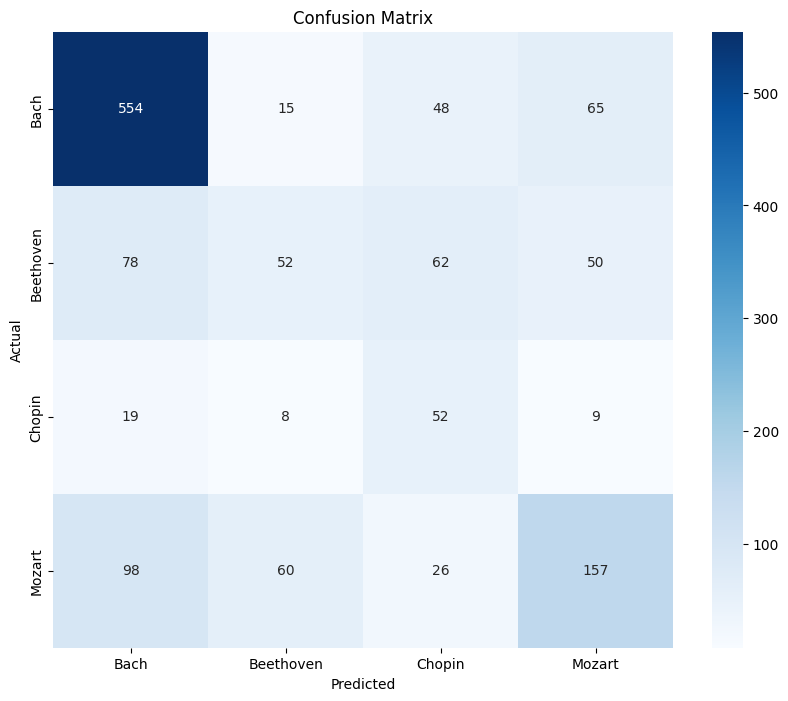

In [28]:
# evaluate the model (on windows)
test_loss, test_acc = model.evaluate(test_windows, test_labels, verbose=2)
print('Test accuracy:', test_acc)

# confusion matrix (on windows)
predictions = model.predict(test_windows)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predictions, )
cm_df = pd.DataFrame(cm, index=num_composer_map.values(), columns=num_composer_map.values())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
def predict_song(model, song_windows):
    song_windows = tf.expand_dims(song_windows, axis=-1)
    window_predictions = model.predict(song_windows)
    summed_predictions = np.sum(window_predictions, axis=0)
    predicted_composer_id = np.argmax(summed_predictions)
    return predicted_composer_id

song_predictions = []
song_true_labels = []

for song in test_songs:
    predicted_composer_id = predict_song(model, song.windows)
    song_predictions.append(predicted_composer_id)
    song_true_labels.append(song.composer_id)

print(classification_report(song_true_labels, song_predictions, target_names=num_composer_map.values()))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
              precision    recall  f1-score   support

        Bach       0.40      1.00      0.57         2
   Beethoven       1.00      0.50      0.67         2
      Chopin       1.00      0.50      0.67         2
      Mozart       1.00      0.50      0.67         2

    accuracy                           0.62         8
   macro avg       0.85      0.62      0.64         8
weighted avg       0.85      0.62      0.64         8

